# Readme



## This is just an basic implementation in order to compare between different model, all of this code were written by me. 

Models are ['BICUBIC','ESPCN', 'FSRCNN', 'LapSRN', 'EDSR'], each pretrained    model weight have to be downloaded and save and the directory above. The pretrained model weight can be downloaded through this github: https://github.com/spmallick/learnopencv.git, there were different model with different scale, I am implememnting on scale x4, so ESPCN_x4.pb, EDSR_x4.pb, FSRCNN_x4.pb amd LapSRN_x4 should be downloaded in order to run this code.

The first image is an image from my datasets just for testing so I am not using large dataset to run. the image can be any image. For the second image it is lenne image where it can be obtain through Set14 dataset. 

I had done simple compare just to compare the whole image through different mode and the zoom in version that we can see more clearly. 

As the result show, the PSNR and SSIM shows difference between different model.

The last part is where I try to add Guassian on the first image to see the 
difference. 




## Note


if there appear error like 'cv2.cv2' has no attribute 'dnn_superres'

please try to run the follows:

pip uninstall opencv-python

pip uninstall opencv-contrib-python

pip install opencv-contrib-python

pip install opencv-contrib-python --upgrade

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [14]:
print('Current opencv version {:s}'.format(cv2.__version__))
print('My working directory is {:s}'.format(os.getcwd()))

Current opencv version 4.5.4
My working directory is /content


In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
#note we may have different directories to store weigts and images
img1 = cv2.imread('/content/drive/MyDrive/ECE570Project/ESPCNV3/lenna.jpg')[...,::-1]
img2 = cv2.imread('/content/drive/MyDrive/ECE570Project/ESPCNV3/dog.jpg')[...,::-1]
#img3 = cv2.imread('Images/IMG_2107.JPEG')[...,::-1]
#img4 = cv2.imread('Images/IMG_2140.JPEG')[...,::-1]

model_names = ['BICUBIC','ESPCN', 'FSRCNN', 'LapSRN', 'EDSR']

In [18]:
#RGB vs YCbCr

def convert_rgb_to_y(img, dim_order='hwc'):
    if dim_order == 'hwc':
        return 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
    else:
        return 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.


def convert_rgb_to_ycbcr(img, dim_order='hwc'):
    if dim_order == 'hwc':
        y = 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
        cb = 128. + (-37.945 * img[..., 0] - 74.494 * img[..., 1] + 112.439 * img[..., 2]) / 256.
        cr = 128. + (112.439 * img[..., 0] - 94.154 * img[..., 1] - 18.285 * img[..., 2]) / 256.
    else:
        y = 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.
        cb = 128. + (-37.945 * img[0] - 74.494 * img[1] + 112.439 * img[2]) / 256.
        cr = 128. + (112.439 * img[0] - 94.154 * img[1] - 18.285 * img[2]) / 256.
    return np.array([y, cb, cr]).transpose([1, 2, 0])


def convert_ycbcr_to_rgb(img, dim_order='hwc'):
    if dim_order == 'hwc':
        r = 298.082 * img[..., 0] / 256. + 408.583 * img[..., 2] / 256. - 222.921
        g = 298.082 * img[..., 0] / 256. - 100.291 * img[..., 1] / 256. - 208.120 * img[..., 2] / 256. + 135.576
        b = 298.082 * img[..., 0] / 256. + 516.412 * img[..., 1] / 256. - 276.836
    else:
        r = 298.082 * img[0] / 256. + 408.583 * img[2] / 256. - 222.921
        g = 298.082 * img[0] / 256. - 100.291 * img[1] / 256. - 208.120 * img[2] / 256. + 135.576
        b = 298.082 * img[0] / 256. + 516.412 * img[1] / 256. - 276.836
    return np.array([r, g, b]).transpose([1, 2, 0])


#By default it calculates psnr for Y channel
#refer to the paper why just Y channel
def cal_psnr(gt, test_img, Ych = True, max_pv = 255):
    if gt.shape != test_img.shape:
        raise ValueError('Two images have different sizes')
    if max_pv == 255: lgmax = 48.1308036086791034124
    else: lgmax = 20*np.log10(max_pv)
    if Ych == True:
        lgse = np.log10(np.sum(
            np.power(convert_rgb_to_y(gt) - 
                   convert_rgb_to_y(test_img), 2)))
        lgm = np.log10(gt.shape[0]*gt.shape[1])
    else:
        lgse = np.log10(np.sum(np.power(cv2.cvtColor(gt, cv2.COLOR_BGR2YCR_CB) - 
           cv2.cvtColor(test_img, cv2.COLOR_BGR2YCR_CB), 2)))
        lgm = np.log10(gt.shape[0]*gt.shape[1]*gt.shape[2])
    return lgmax - 10 * (lgse - lgm)


#For Y channel only
def cal_ssim(gt, test_img, max_pv = 255):
    if gt.shape != test_img.shape:
        raise ValueError('Two images have different sizes')
    gt = convert_rgb_to_y(gt)
    test_img = convert_rgb_to_y(test_img)
    pixel_num = gt.shape[0]*gt.shape[1]
    mux = np.mean(gt); muy = np.mean(test_img)
    sigmasqx = np.mean(np.power((gt - mux), 2))
    sigmasqy = np.mean(np.power((test_img - muy), 2))
    sigmaxy = np.mean((gt - mux)*(test_img - muy))
    c1 = (0.01*max_pv)**2; c2 = (0.03*max_pv)**2
    numerator = (2*mux*muy + c1) * (2*sigmaxy + c2)
    denominator = (mux**2 + muy**2 + c1) * (sigmasqx + sigmasqy + c2)
    return numerator/denominator


#straightforward, mag := magnification
def my_upsample(img, model, mag):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    try:
        sr.readModel('/content/drive/MyDrive/ECE570Project/ESPCNV3/pre_train/{:s}_x{:s}.pb'.format(model,str(mag)))
        sr.setModel(model.lower(), mag)
        return sr.upsample(img, mag)
    except:
        return np.zeros((img.shape[0]*mag, img.shape[1]*mag, 3))


#to compare you want height and width of the original image to be multiple of magnification
#i.e., if your mag = 3, then you would expect the original image to have size 3h by 3w for some integer h, w 
#such that you can calculate psnr and ssim
def simple_compare(img, model, mag, show_metric = False, show_images = True):
    print('======={}_x{}========'.format(model, mag))#str(mag)))
    start = time.time()
    img_h, img_w = img.shape[0], img.shape[1]
    print('input image has size {} by {}'.format(img_h, img_w))
    if show_metric is True:
        if (img_h%mag != 0) or (img_w%mag != 0):
            img_h = int(img_h//mag*mag)
            img_w = int(img_w//mag*mag)
            img = cv2.resize(img, (img_h, img_w), interpolation=cv2.INTER_CUBIC)
            print('Resized the input image to size {} by {}'.format(img_h, img_w))
    if model == 'BICUBIC':
        res = cv2.resize(cv2.resize(img, (img_w//mag, img_h//mag), interpolation=cv2.INTER_CUBIC), 
                         (img_w//mag*mag, img_h//mag*mag), interpolation=cv2.INTER_CUBIC)
    else:
        res = my_upsample(cv2.resize(img, (img_w//mag, img_h//mag), interpolation=cv2.INTER_CUBIC), model, mag)
    res_h, res_w = res.shape[0], res.shape[1]
    print('output image has size {} by {}'.format(res_h, res_w))
    if show_images:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
        ax1.axes.xaxis.set_visible(False); ax1.axes.yaxis.set_visible(False)
        ax2.axes.xaxis.set_visible(False); ax2.axes.yaxis.set_visible(False)
        ax1.imshow(img); ax2.imshow(res)
    if show_metric is True:
        print('PSNR is {:.2f}'.format(cal_psnr(img, res)))
        print('SSIM is {:.4f}'.format(cal_ssim(img, res)))
    print('Wall Time Used = {:.4f} s'.format(time.time()-start))
    return None


def my_imshow(img):
    plt.axis('off'); fig = plt.gcf()
    fig.set_size_inches((img.shape[1]/100, img.shape[0]/100))
    plt.imshow(img)
#modeln_lookup = {'EDSR': 'edsr', 'ESPCN': 'espcn', 'FSRCNN': 'fsrcnn', }

In [23]:
def draw_box(dwin, uwin, rwin, lwin, lw):
    plt.plot([lwin, rwin], [dwin, dwin], linewidth = lw, c ='r')
    plt.plot([lwin, rwin], [uwin, uwin], linewidth = lw, c ='r')
    plt.plot([lwin, lwin], [dwin, uwin], linewidth = lw, c ='r')
    plt.plot([rwin, rwin], [dwin, uwin], linewidth = lw, c ='r')
    return None


#for now let's say we just support equal sides for the zoom_in window
#if the window extends out of the box we set a hard truncation
def zoom_compare(img, centerx, centery, size, model, mag, do_compare = True, show_metric = False, show_images = True):
    img_h, img_w = img.shape[0], img.shape[1]
    if (centerx+size) >= 1:
        lwin = img_w - 1
    else: lwin = int(img_w * (centerx+size))
    if (centerx-size) <= 0:
        rwin = 0
    else: rwin = int(img_w * (centerx-size))
    if (centery+size) >= 1:
        uwin = img_h - 1
    else: uwin = int(img_h * (centery+size))
    if (centery-size) <= 0:
        dwin = 0
    else: dwin = int(img_h * (centery-size))
    if do_compare:
        simple_compare(img[dwin:uwin, rwin:lwin], model, mag, show_metric = show_metric, show_images = show_images)
        return None
    else:
        return (dwin, uwin, rwin, lwin)


#it will show metrics and images and compare all models we have
#for now just support mag = 2, 3, 4 and for 3 it shows nothing for lapsrn
def the_ultimate_compare(img, centerx, centery, size, mag, show_metric = True):
    img_h, img_w = img.shape[0], img.shape[1]
    dwin, uwin, rwin, lwin = zoom_compare(img, centerx, centery, size, 'ph', mag, do_compare = False)
    plt.title('Original, whole')
    plt.axis('off'); fig = plt.gcf()
    fig.set_size_inches((img_w/100, img_h/100))
    draw_box(dwin, uwin, rwin, lwin, 5)
    plt.imshow(img)
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 25))#(2*(lwin-rwin)/100, 2*(uwin-dwin)/100))
    [a.set_axis_off() for a in axes.ravel()]
    #update img, hence update its h and w
    img = img[dwin:uwin, rwin:lwin]
    #print(img.shape)
    img_h, img_w = img.shape[0], img.shape[1]
    if show_metric is True:
        if (img_h%mag != 0) or (img_w%mag != 0):
            img_h = int(img_h//mag*mag)
            img_w = int(img_w//mag*mag)
            img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_CUBIC)
            #print(img.shape)
            print('Resized the input image to size {} by {}'.format(img_h, img_w))
    axes[0][0].imshow(img)#[dwin:uwin, rwin:lwin])
    axes[0][0].set_title('GT')
    plt.tight_layout()
    for (i, j), ax in np.ndenumerate(axes):
        if i+j == 0: continue
        model = model_names[2*i+j-1]
        start = time.time()
        if model == 'BICUBIC':
            res = cv2.resize(cv2.resize(img, (img_w//mag, img_h//mag), interpolation=cv2.INTER_CUBIC), 
                         (img_w//mag*mag, img_h//mag*mag), interpolation=cv2.INTER_CUBIC)
        else: res = my_upsample(cv2.resize(img, (img_w//mag, img_h//mag), interpolation=cv2.INTER_CUBIC), model, mag)
        #print(img.shape)
        #print(res.shape)
        axes[i][j].set_title(model +'_x{}, '.format(mag)+
                        'PSNR = {:.2f}, '.format(cal_psnr(img, res))+
                        'SSIM = {:.3f}, '.format(cal_ssim(img, res))+
                        'wallT = {:.4f}'.format(time.time()-start))
        axes[i][j].imshow(res)
    return None




Resized the input image to size 192 by 144


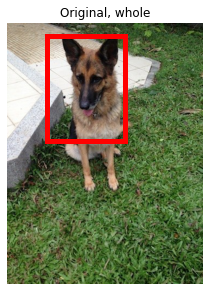

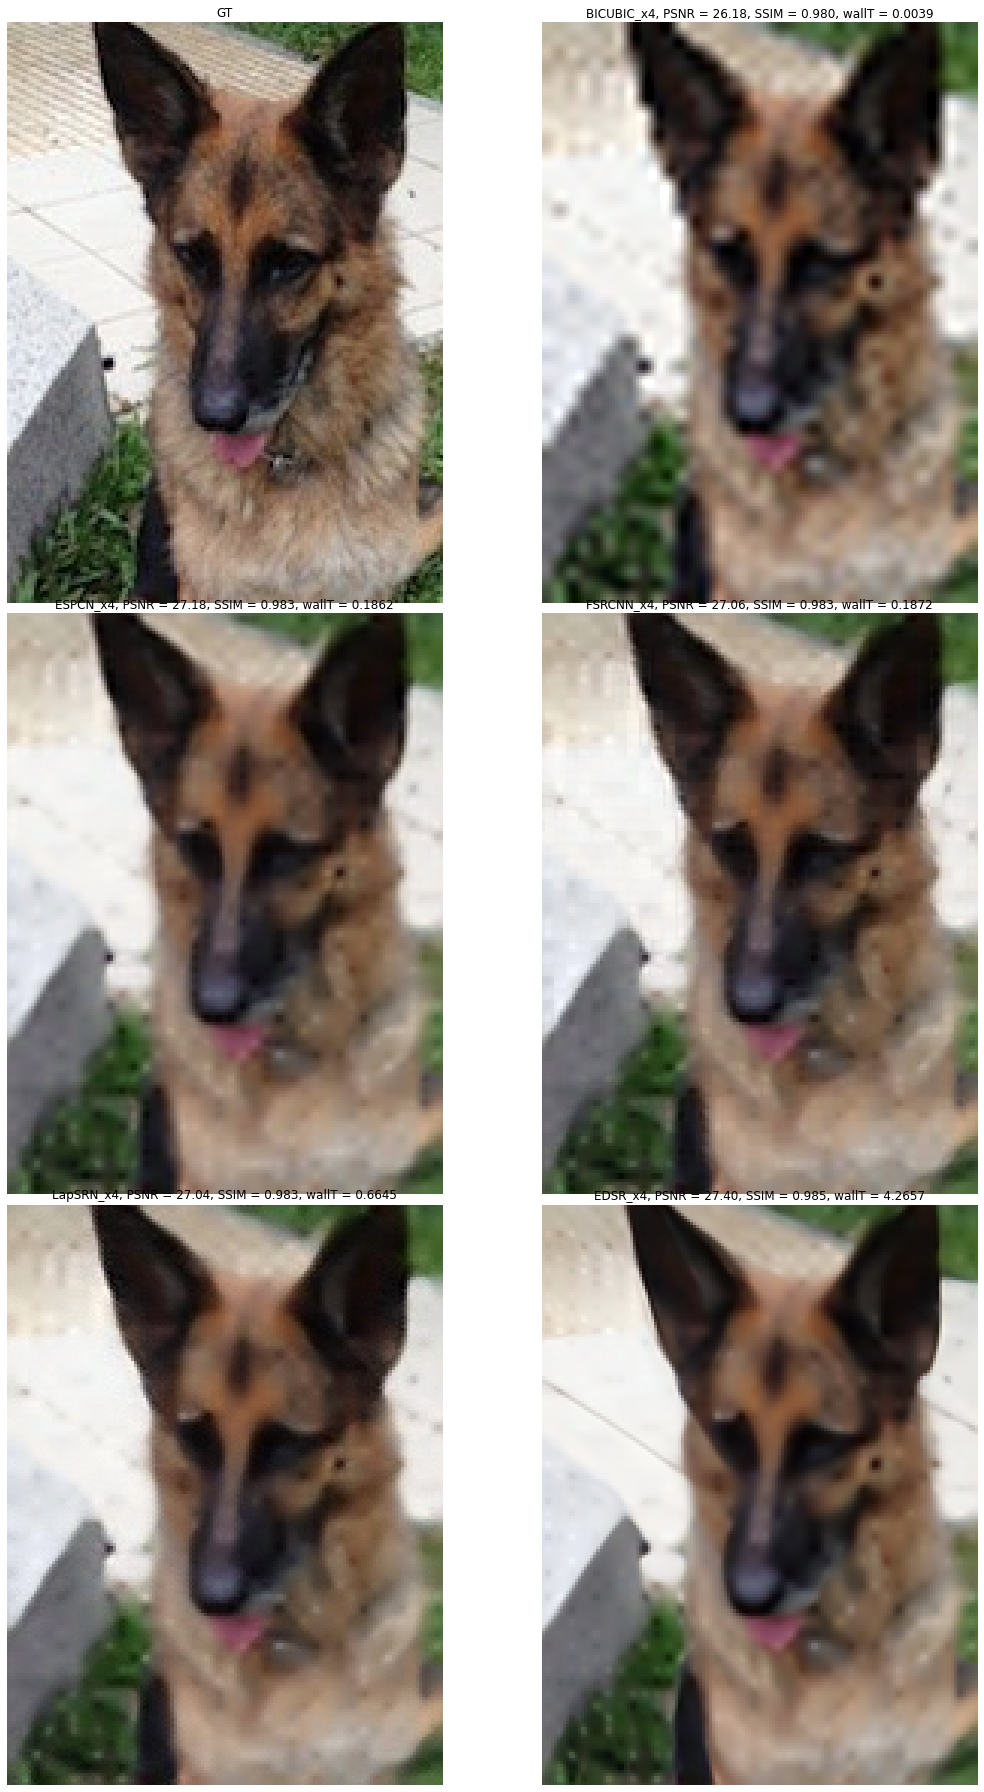

In [21]:
the_ultimate_compare(img2, 0.40, 0.25, 0.20, 4)

In [25]:
simple_compare(img1, 'EDSR', 4, show_metric = True, show_images = True)
simple_compare(img1, 'ESPCN', 4, show_metric = True, show_images = True)
simple_compare(img1, 'FSRCNN', 4, show_metric = True, show_images = True)
simple_compare(img1, 'BICUBIC', 4, show_metric = True, show_images = True)
simple_compare(img1, 'LapSRN', 4, show_metric = True, show_images = True)
#for i in range(3):
#    print(img[...,i].max())

#plt.figure(figsize = (10, 10))
#plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
import scipy.stats as sps
import numpy as np

In [27]:
c_table = np.array([[39, 63],[30961, 62000 - (31000+102) +39]])
print(c_table)
print(sps.fisher_exact(c_table, alternative = 'less'))

[[   39    63]
 [30961 30937]]
(0.6185677526719483, 0.011094091844052023)


In [28]:
x = np.array([0.9, -0.9, 4.3, 2.9, 1.2, 3.0, 2.7, 0.6, 3.6, -0.5])
t_score = np.mean(x)*np.sqrt(len(x))/np.std(x, ddof = 1)
p_val = sps.t.sf(t_score, 9)
print(t_score)
print(p_val)

3.183538302218873
0.005560692749284683


22.425048859123883


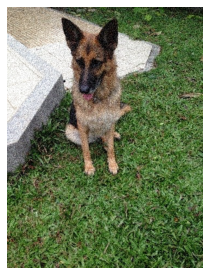

In [29]:
#test gaussian noise
def add_gaussian_noise(img, sigma, ych = False):
    if not ych:
        gaussian_noise = np.random.normal(0, sigma, (img.shape[0], img.shape[1], 3))
        return np.clip(img+gaussian_noise, 0, 255).astype('uint8')
    else:
        img = convert_rgb_to_ycbcr(img)
        gaussian_noise = np.random.normal(0, sigma, (img.shape[0], img.shape[1]))
        img[...,0] += gaussian_noise
        return np.clip(convert_ycbcr_to_rgb(img), 0, 255).astype('uint8')
#my_imshow(img2)
#print(img2.dtype)
temp=add_gaussian_noise(img2, 20, ych=True)
#print(temp.dtype)
my_imshow(temp)
print(cal_psnr(img2, temp))